In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cd ..

/home/anton/rurec


### NAICS codes of FAI industries

In [3]:
with open('data/fai.json') as f:
    fai_naics = json.load(f)
with open('data/fai_subsectors.json') as f:
    fai_subsectors = json.load(f)

fai_subs_codes = []
for x in fai_subsectors.values():
    fai_subs_codes += x.keys()
    
# "fai.json" has 168 codes and includes farming and 12 other industries, "fai_subsectors.json" has 100 codes
fai_naics = fai_subs_codes

### Load InfoGroup employment data

In [4]:
query = '''
SELECT
  year,
  naics,
  cbsa_level,
  sum(employees) as emp
FROM
  (select employees, year, cbsa_level, substr(naics, 1, 6) as naics from `original.data`)
GROUP BY
  year,
  naics,
  cbsa_level
ORDER BY
  year,
  naics
'''

df = pd.read_gbq(query, dialect='standard', project_id='info-group-162919')
df = df[df.naics.notnull()]
df = df[df.naics.str.startswith('1151') | ~df.naics.str.startswith('11')]

### Industry classification: FAI and subsectors

In [5]:
df['fai'] = df.naics.isin(fai_naics)
df['subsector'] = None
for subsector, codes in fai_subsectors.items():
    df.loc[df.naics.isin(codes), 'subsector'] = subsector
df.subsector = df.subsector.astype('category')

### Space classification: rural, micropolitan, metropolitan

In [6]:
area_df = {
    'Rural': df[df.cbsa_level.isnull()],
    'Micropolitan': df[df.cbsa_level == '1'],
    'Metropolitan': df[df.cbsa_level == '2'] 
}

### Plot employment share in FAI

In [7]:
def emp_share_fai(df):
    'Employment share in FAI industries by year.'
    _df = df.groupby(['year', 'fai'])['emp'].sum().unstack()
    return _df[True] / _df.sum(axis=1)

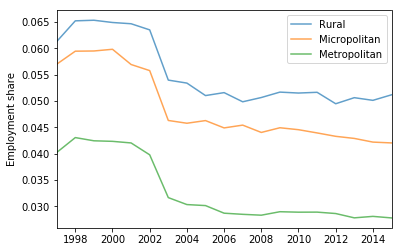

In [8]:
fig, ax = plt.subplots()
for area, adf in area_df.items():
    share = emp_share_fai(adf)
    years = share.index
    ax.plot(years, share, label=area, alpha=0.7)
    ax.set_ylabel('Employment share')
    ax.set_xlim(years.min(), years.max())
lgd = ax.legend(loc='upper right');
fig.savefig('fig/fai_dynamics.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

### Plot breakdown of FAI employment

In [9]:
def fai_emp_breakdown(df):
    _df = df.groupby(['year', 'subsector'])['emp'].sum().unstack()
    _sum = _df.sum(axis=1)
    return _df.apply(lambda col: col / _sum)

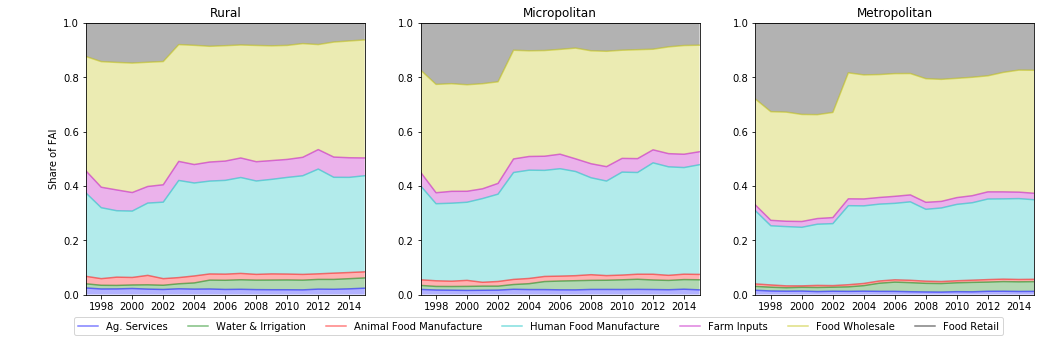

In [10]:
colors = ['b','g','r','c','m','y','k']
fig, axes = plt.subplots(ncols=3, figsize=(17, 5))
axes[0].set_ylabel('Share of FAI')
lines = []
for (area, adf), ax in zip(area_df.items(), axes):
    shares = fai_emp_breakdown(adf)
    years = shares.index
    cum_share1 = np.zeros(len(shares))
    for subsector, color in zip(fai_subsectors, colors):
        cum_share0 = cum_share1.copy()
        share = shares[subsector]
        cum_share1 += share
        line = ax.plot(years, cum_share1, color, alpha=0.5, label=subsector)
        lines.append(line[0])
        ax.fill_between(years, cum_share0, cum_share1, facecolor=color, alpha=0.3)
    ax.set_title(area)
    ax.set_ylim(-0.0001,1)
    ax.set_xlim(years.min(), years.max())
lines = lines[:len(fai_subsectors)]
lgd = fig.legend(handles=lines, ncol=len(lines), loc='upper center', bbox_to_anchor=(0.44, 0.08))
fig.savefig('fig/fai_breakdown.png', bbox_extra_artists=(lgd,), bbox_inches='tight')